# 🤖 Modelado Predictivo del Dataset

En esta sección se construyen modelos predictivos para estimar la probabilidad de éxito (*target*) de cada candidato.  
El objetivo es:

- Entrenar modelos supervisados que capturen la relación entre variables explicativas y target
- Evaluar la importancia de cada variable
- Comparar distintas técnicas y seleccionar la mejor
- Preparar submodelos según área académica (Medicina, Enfermería, resto)

El proceso se divide en los siguientes pasos:
1. Preparación de datos y división en entrenamiento/test  
2. Selección de modelos factibles  
3. Selección de variables importantes  
4. Entrenamiento de submodelos  
5. Optimización de hiperparámetros  
6. Evaluación del modelo sobre conjunto test

---

## 1️⃣ Preparación de Datos

Antes de entrenar los modelos:

- Se eliminan variables irrelevantes o identificadores
- Se manejan valores nulos
- Se divide el dataset en **conjunto de entrenamiento** (70–80 %) y **conjunto de test** (20–30 %)
- Se crean subdatasets si se requiere segmentación por área académica

📌 Esto asegura que el modelo no vea datos de test durante el entrenamiento, evitando sobreajuste.

---

## 2️⃣ Selección de Modelos

Se consideran modelos supervisados robustos para clasificación/regresión según el target:

- **Random Forest**: Modelo basado en árboles con gran capacidad de generalización  
- **Gradient Boosting Machines (GBM/XGBoost/LightGBM)**: Optimización secuencial de errores  
- **Regresiones**: Lineales o logísticas, útiles para interpretación  
- Otros modelos factibles según el caso (SVM, redes neuronales simples)

Se busca evaluar cuál combina mejor:

- Precisión o % acierto
- AUC (Área bajo la curva ROC)
- Interpretabilidad
- Robustez ante outliers y variables correlacionadas

---

## 3️⃣ Selección de Variables Importantes

- Se utiliza la importancia que cada modelo asigna a las variables para:

  - Reducir dimensionalidad
  - Evitar ruido
  - Mejorar interpretabilidad

- Variables con mayor impacto en la predicción serán prioridad para la construcción de submodelos.

📌 Ejemplo: `feature_importances_` en Random Forest o `SHAP values` para interpretabilidad avanzada.

---

## 4️⃣ Entrenamiento de Submodelos

- Se pueden crear modelos específicos para segmentos de interés:  
  - Medicina  
  - Enfermería  
  - Resto de candidatos

- Esto permite capturar patrones particulares de cada área que un modelo general podría diluir.

---

## 5️⃣ Optimización de Hiperparámetros

- Se aplican técnicas de tuning automático (grid search, random search o frameworks como **PyCaret**)  
- Se buscan combinaciones que maximizan métricas clave:  

  - Precisión / Recall  
  - AUC / ROC  
  - F1-score  

- El objetivo es **obtener el mejor modelo posible** sin sobreajustar a los datos de entrenamiento.

---

## 6️⃣ Evaluación en Conjunto de Test

- Una vez seleccionado el modelo óptimo, se evalúa sobre datos no vistos:

  - Comprobando métricas globales: % acierto, AUC  
  - Detectando posibles sesgos por segmento  
  - Verificando estabilidad y consistencia de predicciones

- Esto garantiza que el modelo generalice y pueda usarse para predicciones futuras.

---

## 🔍 Conclusiones del Modelado

El modelado supervisado permite:

- Predecir con alta fiabilidad la probabilidad de éxito de los candidatos  
- Entender qué variables tienen mayor impacto en la conversión  
- Construir estrategias segmentadas por áreas académicas  
- Complementar el análisis de clusters previo, combinando insights no supervisados y supervisados

📌 Los resultados servirán como base para:

- Implementación de modelos en producción
- Definición de estrategias de admisión diferenciadas
- Análisis de riesgo y priorización de candidatos


✅ Dataset tras excluir Máster: (521101, 58)

📌 Visita Campus - Distribución
CH_VISITACAMPUS__PC
False    405863
True     115230
NaN           8
Name: count, dtype: int64
CH_VISITACAMPUS__PC
False    77.885669
True     22.112796
NaN       0.001535
Name: proportion, dtype: float64

📌 FO_rentaFam_ges__c - NA: 88.96%

📌 CH_MATRICULA_SUJETA_BECA - NA: 0.00%

⚠️ Etapas NO contempladas en el orden (asignadas a 0):
etapa_compuesta
Matrícula OOGG__Formalizada                     207504
Resolución__Publicada                           133481
Cerrada/Perdida__NA                              73036
Reorientación__Respuesta candidato               30631
Inicio__NA                                       14503
Matrícula Admisión__Desmatriculado               13763
Matrícula Admisión__Matriculado parcialmente     12813
Pruebas de admisión__No presentado               11744
Matrícula Admisión__Inicio                        9080
Validación__Completa                              4456
Stand By__Validada     

                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9835  0.9970  0.9744  0.9859   
dt               Decision Tree Classifier    0.9869  0.9952  0.9760  0.9926   
lightgbm  Light Gradient Boosting Machine    0.9285  0.9812  0.9567  0.8819   
lr                    Logistic Regression    0.8873  0.9532  0.8584  0.8696   

              F1   Kappa     MCC  TT (Sec)  
rf        0.9801  0.9660  0.9661    4.6033  
dt        0.9842  0.9731  0.9732    2.0967  
lightgbm  0.9177  0.8547  0.8569    2.4633  
lr        0.8640  0.7678  0.7678    2.4300  


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9151  0.9721  0.9635  0.8522  0.9044  0.8286  0.8337
1       0.9153  0.9726  0.9624  0.8533  0.9046  0.8290  0.8338
2       0.9153  0.9725  0.9616  0.8536  0.9044  0.8288  0.8335
Mean    0.9152  0.9724  0.9625  0.8531  0.9045  0.8288  0.8337
Std     0.0001  0.0002  0.0008  0.0006  0.0001  0.0002  0.0001

🧪 MÉTRICAS EN TEST — Modelo Grado
AUC           : 0.770
Accuracy      : 0.926
Accuracy clase 0 (NO matrícula): 0.926
Accuracy clase 1 (SÍ matrícula): 0.928

📊 MÉTRICAS EN TEST (GRADO)
AUC Test       : 0.770
Accuracy Test  : 0.926
Accuracy Clase 0: 0.926
Accuracy Clase 1: 0.928


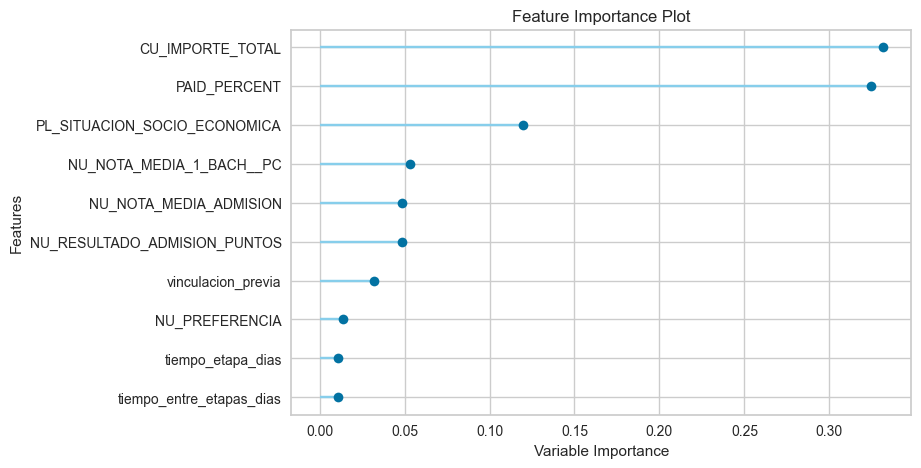

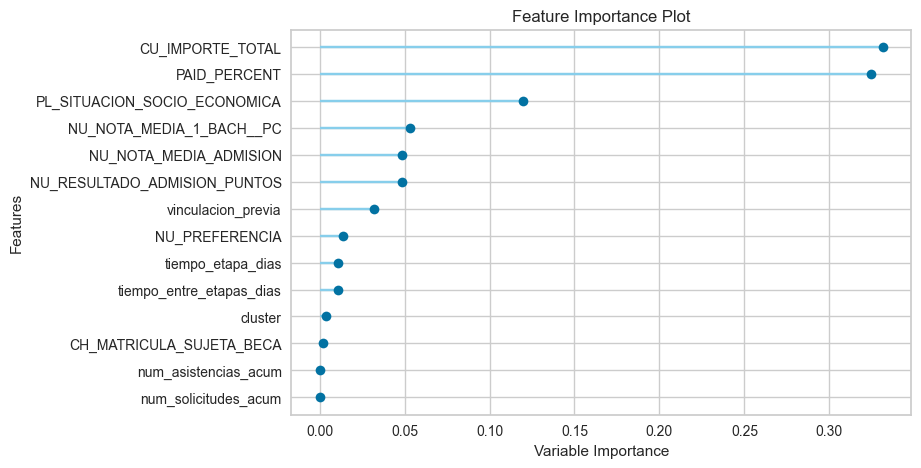

Transformation Pipeline and Model Successfully Saved

✅ Modelo de Grado entrenado, evaluado en TEST y guardado correctamente.


In [2]:
# ============================================================
# SCRIPT · 03 MODELADO PREDICTIVO GRADO CON PYCARET 
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import (
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

def metricas_test(nombre_modelo, preds, y_test, target='target'):
    """
    Calcula métricas clave en el conjunto de test
    """
    # Crear la probabilidad de la clase positiva si no existe
    if 'probabilidad_matricula' not in preds.columns:
        preds['probabilidad_matricula'] = 1 - preds['prediction_score']

    auc = roc_auc_score(y_test, preds['probabilidad_matricula']) \
          if y_test.nunique() > 1 else np.nan

    acc = accuracy_score(y_test, preds['prediction_label'])

    acc_0 = (
        (preds[y_test == 0]['prediction_label'] == 0).mean()
        if (y_test == 0).sum() > 0 else np.nan
    )

    acc_1 = (
        (preds[y_test == 1]['prediction_label'] == 1).mean()
        if (y_test == 1).sum() > 0 else np.nan
    )

    print(f"\n🧪 MÉTRICAS EN TEST — {nombre_modelo}")
    print(f"AUC           : {auc:.3f}")
    print(f"Accuracy      : {acc:.3f}")
    print(f"Accuracy clase 0 (NO matrícula): {acc_0:.3f}")
    print(f"Accuracy clase 1 (SÍ matrícula): {acc_1:.3f}")

    return {
        'Modelo': nombre_modelo,
        'AUC_test': auc,
        'Accuracy_test': acc,
        'Accuracy_0_test': acc_0,
        'Accuracy_1_test': acc_1
    }



# ============================================================
# 0️⃣ CARGA DEL DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
df_raw = df.copy()  # para auditoría de NA

target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO GRADO (EXCLUYE MÁSTER)
# ============================================================

if 'TITULACION' in df.columns:
    df = df[~df['TITULACION'].str.contains('MASTER', case=False, na=False)]
else:
    raise ValueError("❌ No existe la columna TITULACION")

print(f"✅ Dataset tras excluir Máster: {df.shape}")

# ============================================================
# 🔹 VISITA CAMPUS (GRADO)
# ============================================================

if 'CH_VISITACAMPUS__PC' in df.columns:
    print("\n📌 Visita Campus - Distribución")
    print(df['CH_VISITACAMPUS__PC'].value_counts(dropna=False))
    print(df['CH_VISITACAMPUS__PC'].value_counts(normalize=True, dropna=False) * 100)
else:
    print("❌ CH_VISITACAMPUS__PC no existe")

# ============================================================
# 🔹 RENTA FAMILIAR Y BECA (DIAGNÓSTICO)
# ============================================================

for v in ['FO_rentaFam_ges__c', 'CH_MATRICULA_SUJETA_BECA']:
    if v in df.columns:
        na_perc = df[v].isna().mean() * 100
        print(f"\n📌 {v} - NA: {na_perc:.2f}%")
    else:
        print(f"❌ {v} no existe")

# ============================================================
# 🔹 CONSTRUCCIÓN ETAPA ORDINAL 
# ============================================================

if {'STAGENAME', 'PL_SUBETAPA'}.issubset(df.columns):

    df['etapa_compuesta'] = (
        df['STAGENAME'].fillna("NA") + "__" +
        df['PL_SUBETAPA'].fillna("NA")
    )

    # ⚠️ ORDEN DEFINIDO EXPLÍCITAMENTE (NO sorted)
    orden_etapas = {
        'Lead__NA': 0,
        'Contactado__NA': 1,
        'Interesado__NA': 2,
        'Solicitud__En curso': 3,
        'Solicitud__Completa': 4,
        'Admitido__NA': 5,
        'Matriculado__NA': 6
    }

    df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

    # 🔍 Detectar combinaciones no contempladas
    etapas_no_mapeadas = df.loc[
        df['etapa_ordinal_num'].isna(),
        'etapa_compuesta'
    ].value_counts()

    if not etapas_no_mapeadas.empty:
        print("\n⚠️ Etapas NO contempladas en el orden (asignadas a 0):")
        print(etapas_no_mapeadas)

    # 🛡️ Garantizar que NO haya NA (criterio de negocio)
    df['etapa_ordinal_num'] = df['etapa_ordinal_num'].fillna(0)

else:
    print("❌ No se puede crear etapa ordinal")


# ============================================================
# 0️⃣.2 LIMPIEZA BÁSICA
# ============================================================

cols_id = ['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE']

#Copiamos el dataset completo antes de eliminar columnas
df_full = df.copy()

df = df.drop(columns=[c for c in cols_id if c in df.columns])
df = df.dropna(subset=[target])

# ============================================================
# 🔎 DIAGNÓSTICO RENTA / BECA (ANTES DE IMPUTAR)
# ============================================================

# 🔹 IMPUTACIÓN RENTA Y BECA
if 'FO_rentaFam_ges__c' in df.columns:
    df['FO_rentaFam_ges__c'] = df['FO_rentaFam_ges__c'].fillna(df['FO_rentaFam_ges__c'].mean())

if 'CH_MATRICULA_SUJETA_BECA' in df.columns:
    df['CH_MATRICULA_SUJETA_BECA'] = df['CH_MATRICULA_SUJETA_BECA'].fillna(0).astype(int)

print("\n📌 Revisión renta y beca (Máster):")
print(df['FO_rentaFam_ges__c'].isna().mean(), df['CH_MATRICULA_SUJETA_BECA'].value_counts(normalize=True))

# ============================================================
# 0️⃣.3 IMPUTACIÓN LÓGICA DE NA
# ============================================================

# 🔹 Variables donde NA = 0 tiene sentido de negocio
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

# 🔹 Renta familiar → imputación por media
if 'FO_rentaFam_ges__c' in df.columns:
    renta_media = df['FO_rentaFam_ges__c'].mean()
    df['FO_rentaFam_ges__c'] = df['FO_rentaFam_ges__c'].fillna(renta_media)

# 🔹 Variables binarias → imputar a 0 (False)
vars_binarias = [
    'CH_MATRICULA_SUJETA_BECA'
]

for v in vars_binarias:
    if v in df.columns:
        df[v] = df[v].fillna(0)

# 🔍 Control final de NA
print("\n📌 NA restantes por variable:")
print(df.isna().sum().loc[lambda x: x > 0])


# ============================================================
# 🔗 FEATURE: VINCULACIÓN PREVIA
# ============================================================

cols_vinculacion = [
    'CH_ALUMNO__PC', 'CH_ESTUDIANTE__PC', 'CH_ANTIGUO_ALUMNO__PC',
    'CH_ALUMNI__PC', 'CH_ANTIGUOALUMNO_INTERCAMBIO',
    'CH_HIJO_ANTIGUO_ALUMNO__PC'
]

existentes = [c for c in cols_vinculacion if c in df.columns]
df['vinculacion_previa'] = df[existentes].max(axis=1)

# ============================================================
# 🔢 FEATURE: ETAPA ORDINAL
# ============================================================

df['etapa_compuesta'] = df['STAGENAME'].astype(str) + "__" + df['PL_SUBETAPA'].astype(str)

print("\n📌 Etapas reales:")
print(df['etapa_compuesta'].value_counts())

orden_etapas = {
    'Lead__Nuevo': 1,
    'Lead__Contactado': 2,
    'Admisión__En evaluación': 3,
    'Admisión__Admitido': 4,
    'Matrícula__Pendiente': 5,
    'Matrícula__Pagada': 6
}

df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

# 🔍 CONTROL DE NAs EN ETAPA ORDINAL
etapas_no_mapeadas = (
    df.loc[df['etapa_ordinal_num'].isna(), 'etapa_compuesta']
    .value_counts()
)

if not etapas_no_mapeadas.empty:
    print("\n⚠️ Etapas sin correspondencia ordinal:")
    print(etapas_no_mapeadas)

# 🛡️ Garantizar que no haya NA (criterio de negocio)
df['etapa_ordinal_num'] = df['etapa_ordinal_num'].fillna(0)

# ============================================================
# 🔹 VINCULACIÓN PREVIA
# ============================================================

cols_vinculacion = [
    'CH_ALUMNO__PC', 'CH_ESTUDIANTE__PC', 'CH_ANTIGUO_ALUMNO__PC',
    'CH_ALUMNI__PC', 'CH_ANTIGUOALUMNO_INTERCAMBIO',
    'CH_HIJO_ANTIGUO_ALUMNO__PC'
]

existentes = [c for c in cols_vinculacion if c in df.columns]

if existentes:
    df['vinculacion_previa'] = (
        df[existentes]
        .fillna(False)
        .astype(int)
        .max(axis=1)
    )

    print("\n📌 Distribución vinculación_previa:")
    print(df['vinculacion_previa'].value_counts(normalize=True))

else:
    print("❌ No existen variables de vinculación previa de antiguos alumnos")




# ============================================================
# 1️⃣ SELECCIÓN DE VARIABLES
# ============================================================

vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX',
    'YEARPERSONBIRTHDATE', 'PAID_AMOUNT',
    'PC1', 'PC2'
]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].dropna().sort_values().unique()
curso_test = cursos[-2]
curso_excluido = cursos[-1]

train_df_full = df[~df['PL_CURSO_ACADEMICO'].isin([curso_test, curso_excluido])]
test_df_full_model = df[df['PL_CURSO_ACADEMICO'] == curso_test]

test_df_full_excel = (
    df_full[df_full['PL_CURSO_ACADEMICO'] == curso_test]
    .reset_index(drop=True)
)


X_train = train_df_full[vars_modelado]
y_train = train_df_full[target]
X_test  = test_df_full_model[vars_modelado]
y_test  = test_df_full_model[target]


print(f"✅ Train: {X_train.shape} | Test: {X_test.shape}")

# ============================================================
# 3️⃣ FILTRADO DE COLUMNAS PROBLEMÁTICAS
# ============================================================

object_cols = X_train.select_dtypes(include='object').columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
pca_cols = ['PCA1', 'PCA2', 'PC1', 'PC2']

safe_cols = [
    c for c in X_train.columns
    if c not in object_cols + const_cols + pca_cols
]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ SETUP PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    pca=False,
    remove_multicollinearity=False,
    verbose=False,
    html=False
)

# ============================================================
# 5️⃣ MODELADO
# ============================================================

best_model = compare_models(
    include=['lr', 'dt', 'rf', 'lightgbm'],
    sort='AUC',
    turbo=True
)

# Juan: ¿Qué tipos de "optimize" hay? Esto lo reviso yo por curiosidad
best_model = tune_model(best_model, optimize='AUC', n_iter=10)

# ============================================================
# 6️⃣ VALIDACIÓN EN TEST (CLAVE PARA JUAN)
# ============================================================

test_df = test_df_full_model[safe_cols].reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

preds = predict_model(best_model, data=test_df)
preds[target] = y_test

metricas_master = metricas_test(
    nombre_modelo="Modelo Grado",
    preds=preds,
    y_test=y_test,
    target=target
)

# Probabilidad real de matrícula (P(y=1))
preds['prob_matricula_real'] = preds.apply(
    lambda x: x['prediction_score']
    if x['prediction_label'] == 1
    else (1 - x['prediction_score']),
    axis=1
)

# Confianza del modelo (distancia a la indecisión)
preds['confianza_modelo'] = (preds['prob_matricula_real'] - 0.5).abs() * 2
 #Juan: esto está perfecto. Aquí tengo que darle una vuelta porque el prediction score es la confianza que le da el modelo al target. Es decir, un valor bajo indica que se fía poco de la predicción.

auc_test = roc_auc_score(y_test, preds['probabilidad_matricula'])

acc_test = accuracy_score(y_test, preds['prediction_label'])

acc_0 = (preds[preds[target] == 0]['prediction_label'] == 0).mean()
acc_1 = (preds[preds[target] == 1]['prediction_label'] == 1).mean()

print("\n📊 MÉTRICAS EN TEST (GRADO)")
print(f"AUC Test       : {auc_test:.3f}")
print(f"Accuracy Test  : {acc_test:.3f}")
print(f"Accuracy Clase 0: {acc_0:.3f}")
print(f"Accuracy Clase 1: {acc_1:.3f}")

# ============================================================
# 7️⃣ DATASET TEST COMPLETO CON SCORING
# ============================================================

df_test_completo = pd.concat(
    [
        test_df_full_excel,
        preds[['prediction_label', 'prob_matricula_real']]
    ],
    axis=1
)

assert len(test_df_full_excel) == len(preds), "❌ Desalineación filas test vs preds"

ruta_excel = r"..\datos\03. Datos analizados\test_grado_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 8️⃣ IMPORTANCIA DE VARIABLES
# ============================================================

plot_model(best_model, plot='feature')
plot_model(best_model, plot='feature_all')

# ============================================================
# 9️⃣ GUARDADO DEL MODELO
# ============================================================

save_model(best_model, r"..\datos\04. Modelos\modelo_final_grado")

print("\n✅ Modelo de Grado entrenado, evaluado en TEST y guardado correctamente.")


In [ ]:
# ============================================================
# SCRIPT · MODELADO PREDICTIVO MÁSTER CON PYCARET
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import (
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

def comprobar_historial_etapas(df, id_col='ID'):
    resumen = (
        df.groupby(id_col)['etapa_compuesta']  # columna con etapa/subetapa
          .agg(lambda x: set(x))
          .reset_index()
    )
    resumen['num_etapas'] = resumen['etapa_compuesta'].apply(len)
    return resumen

hist_train = comprobar_historial_etapas(train_df)
hist_test  = comprobar_historial_etapas(test_df)

print(hist_train.head())
print(hist_test.head())

# ============================================================
# FUNCIÓN MÉTRICAS TEST
# ============================================================

def metricas_test(nombre_modelo, preds, y_test, target='target'):
    auc = roc_auc_score(y_test, preds['prediction_score']) \
          if y_test.nunique() > 1 else np.nan

    acc = accuracy_score(y_test, preds['prediction_label'])

    acc_0 = (
        (preds[y_test == 0]['prediction_label'] == 0).mean()
        if (y_test == 0).sum() > 0 else np.nan
    )

    acc_1 = (
        (preds[y_test == 1]['prediction_label'] == 1).mean()
        if (y_test == 1).sum() > 0 else np.nan
    )

    print(f"\n🧪 MÉTRICAS EN TEST — {nombre_modelo}")
    print(f"AUC           : {auc:.3f}")
    print(f"Accuracy      : {acc:.3f}")
    print(f"Accuracy clase 0 (NO matrícula): {acc_0:.3f}")
    print(f"Accuracy clase 1 (SÍ matrícula): {acc_1:.3f}")

    return {
        'Modelo': nombre_modelo,
        'AUC_test': auc,
        'Accuracy_test': acc,
        'Accuracy_0_test': acc_0,
        'Accuracy_1_test': acc_1
    }

# ============================================================
# 0️⃣ CARGA DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO MÁSTER
# ============================================================

df = df[df['TITULACION'].str.contains('MASTER', case=False, na=False)]
print(f"✅ Dataset Máster: {df.shape}")

# ============================================================
# 🔹 VISITA CAMPUS (GRADO)
# ============================================================

if 'CH_VISITACAMPUS__PC' in df.columns:
    print("\n📌 Visita Campus - Distribución")
    print(df['CH_VISITACAMPUS__PC'].value_counts(dropna=False))
    print(df['CH_VISITACAMPUS__PC'].value_counts(normalize=True, dropna=False) * 100)
else:
    print("❌ CH_VISITACAMPUS__PC no existe")

# ============================================================
# 0️⃣.2 DIAGNÓSTICO RENTAS Y BECAS
# ============================================================
# 🔹 IMPUTACIÓN RENTA Y BECA
if 'FO_rentaFam_ges__c' in df.columns:
    df['FO_rentaFam_ges__c'] = df['FO_rentaFam_ges__c'].fillna(df['FO_rentaFam_ges__c'].mean())

if 'CH_MATRICULA_SUJETA_BECA' in df.columns:
    df['CH_MATRICULA_SUJETA_BECA'] = df['CH_MATRICULA_SUJETA_BECA'].fillna(0).astype(int)

print("\n📌 Revisión renta y beca (Máster):")
print(df['FO_rentaFam_ges__c'].isna().mean(), df['CH_MATRICULA_SUJETA_BECA'].value_counts(normalize=True))


# ============================================================
# 0️⃣.2 LIMPIEZA E IMPUTACIÓN
# ============================================================

# 🔹 Columnas identificativas (no predictivas)
cols_id = ['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE']

df_full = df.copy()  # backup completo

df = df.drop(columns=cols_id, errors='ignore')

# 🔹 Eliminar filas sin target
df = df.dropna(subset=[target])

# ============================================================
# 🔹 IMPUTACIÓN LÓGICA
# ============================================================

# 1️⃣ Variables numéricas donde NA = 0 tiene sentido
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

# 2️⃣ Renta familiar → imputar con la media
if 'FO_rentaFam_ges__c' in df.columns:
    renta_media = df['FO_rentaFam_ges__c'].mean()
    df['FO_rentaFam_ges__c'] = df['FO_rentaFam_ges__c'].fillna(renta_media)

# 3️⃣ Beca → variable binaria (NA = No)
if 'CH_MATRICULA_SUJETA_BECA' in df.columns:
    df['CH_MATRICULA_SUJETA_BECA'] = df['CH_MATRICULA_SUJETA_BECA'].fillna(0)

# ============================================================
# 🔍 CONTROL FINAL
# ============================================================

print("\n📌 NA restantes por columna (si hay):")
print(df.isna().sum().loc[lambda x: x > 0])


# ============================================================
# 0️⃣.4 FEATURE: VINCULACIÓN PREVIA
# ============================================================

cols_vinculacion = [
    'CH_ALUMNO__PC', 'CH_ESTUDIANTE__PC', 'CH_ANTIGUO_ALUMNO__PC',
    'CH_ALUMNI__PC', 'CH_ANTIGUOALUMNO_INTERCAMBIO',
    'CH_HIJO_ANTIGUO_ALUMNO__PC'
] #Juan: perfecto
existentes = [c for c in cols_vinculacion if c in df.columns]
if existentes:
    df['vinculacion_previa'] = df[existentes].fillna(False).astype(int).max(axis=1)
    print("\n📌 Distribución vinculación_previa (Máster):")
    print(df['vinculacion_previa'].value_counts(normalize=True))
else:
    print("❌ No existen variables de vinculación previa de antigüos alumnos")


# ============================================================
# 🔹 CONSTRUCCIÓN VARIABLE ORDINAL DE ETAPAS
# ============================================================

if {'STAGENAME', 'PL_SUBETAPA'}.issubset(df.columns):

    df['etapa_compuesta'] = df['STAGENAME'].fillna("NA").astype(str) + "__" + df['PL_SUBETAPA'].fillna("NA").astype(str)


    orden_etapas = {
        'Lead__NA': 0,
        'Contactado__NA': 1,
        'Interesado__NA': 2,
        'Solicitud__En curso': 3,
        'Solicitud__Completa': 4,
        'Admitido__NA': 5,
        'Matriculado__NA': 6
    }

    df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

else:
    print("❌ No se puede crear etapa ordinal")

# ============================================================
# 1️⃣ VARIABLES (EXCLUSIÓN ROBUSTA)
# ============================================================

vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED', 'CH_PAGO_SUPERIOR',
    'STAGENAME', 'PL_SUBETAPA', 'ACC_DTT_FECHAULTIMAACTIVIDAD',
    'NAMEX', 'YEARPERSONBIRTHDATE', 'PAID_AMOUNT'
]

# ❌ Eliminar cualquier PC / PCA
vars_excluir += [c for c in df.columns if c.upper().startswith('PC')]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].dropna().sort_values().unique()
curso_test = cursos[-2]
curso_excluido = cursos[-1]

train_df_full = df[~df['PL_CURSO_ACADEMICO'].isin([curso_test, curso_excluido])]
test_df_full_model = df[df['PL_CURSO_ACADEMICO'] == curso_test]

hist_train = comprobar_historial_etapas(train_df_full)
hist_test  = comprobar_historial_etapas(test_df_full_model)

print(f"Train IDs: {hist_train.shape[0]} | Test IDs: {hist_test.shape[0]}")

test_df_full_excel = (
    df_full[df_full['PL_CURSO_ACADEMICO'] == curso_test]
    .reset_index(drop=True)
)


X_train = train_df_full[vars_modelado]
y_train = train_df_full[target]
X_test  = test_df_full_model[vars_modelado]
y_test  = test_df_full_model[target]


print(f"✅ Train Máster: {X_train.shape} | Test Máster: {X_test.shape}")

# ============================================================
# 3️⃣ FILTRADO FINAL (BLINDADO)
# ============================================================

object_cols = X_train.select_dtypes(include='object').columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
pca_cols = [c for c in X_train.columns if c.upper().startswith('PC')]

safe_cols = [
    c for c in X_train.columns
    if c not in object_cols + const_cols + pca_cols
]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    pca=False,
    verbose=False,
    html=False
)

best_model = compare_models(include=['lightgbm'], sort='AUC')
best_model = tune_model(best_model, optimize='AUC')

# ============================================================
# 5️⃣ VALIDACIÓN EN TEST
# ============================================================

test_df = X_test[safe_cols].reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

preds = predict_model(best_model, data=test_df)
preds[target] = y_test.reset_index(drop=True)

# Añadir ID para poder hacer merge con historial completo
preds['ID'] = test_df_full_excel['ID'].reset_index(drop=True)

# Recuperar historial completo de los IDs en test
ids_test = test_df_full_excel['ID'].unique()
historial_completo = df_full[df_full['ID'].isin(ids_test)].copy()

# Merge de predicciones con todo el historial
historial_completo_scoring = historial_completo.merge(
    preds[['ID', 'prediction_label', 'prob_matricula_real', 'confianza_modelo']],
    on='ID',
    how='left'
)

print("\n📊 Ejemplo resultado final:")
print(historial_completo_scoring.head())

preds['prob_matricula_real'] = preds.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 
    else (1 - x['prediction_score']),
    axis=1
)


metricas_master = metricas_test(
    nombre_modelo="Modelo Máster",
    preds=preds,
    y_test=y_test,
    target=target
)

# ============================================================
# 6️⃣ DATASET TEST COMPLETO
# ============================================================

df_test_completo = pd.concat(
    [
        test_df_full_excel,
        preds[['prediction_label', 'prob_matricula_real']]
    ],
    axis=1
)

assert len(test_df_full_excel) == len(preds), "❌ Desalineación test vs preds"


ruta_excel = r"..\datos\03. Datos analizados\test_master_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 7️⃣ IMPORTANCIA Y GUARDADO
# ============================================================

plot_model(best_model, plot='feature')
plot_model(best_model, plot='feature_all')

save_model(best_model, r"..\datos\04. Modelos\modelo_final_master")

print("\n✅ Modelo Máster entrenado, evaluado en TEST y guardado correctamente.")

#Está perfecto

KeyError: 'Column not found: etapa_compuesta'

In [ ]:
# ============================================================
# 🔹 ANÁLISIS EXPLORATORIO Y CONSTRUCCIÓN DE VARIABLES ORDINARIAS
# ============================================================

print(df.columns.tolist())
# Revisar variable "Visita Campus" en GRADO
if 'CH_VISITACAMPUS__PC' in df.columns:
    vc_counts = df['CH_VISITACAMPUS__PC'].value_counts(dropna=False)
    vc_perc = df['CH_VISITACAMPUS__PC'].value_counts(normalize=True, dropna=False) * 100
    print("\n📌 Visita Campus - Distribución")
    print(vc_counts)
    print(vc_perc)

    if 'CH_VISITACAMPUS__PC' in safe_cols:
        print("✅ Visita Campus entra en el modelo")
    else:
        print("❌ Visita Campus NO entra en el modelo")


else:
    print("❌ La variable 'Visita Campus' no está en el dataset.")

# Revisar variable "antiguo alumno" en MÁSTER
if 'CH_ANTIGUO_ALUMNO__PC' in df.columns:
    aa_counts = df['CH_ANTIGUO_ALUMNO__PC'].value_counts(dropna=False)
    aa_perc = df['CH_ANTIGUO_ALUMNO__PC'].value_counts(normalize=True, dropna=False) * 100
    print("\n📌 Antiguo alumno - Distribución")
    print(aa_counts)
    print(aa_perc)
else:
    print("❌ La variable 'CH_ANTIGUO_ALUMNO__PC' no está en el dataset.")

# Revisar "renta" y "% de beca"
for var in ['FO_rentaFam_ges__c', 'CH_MATRICULA_SUJETA_BECA']:
    if var in df.columns:
        na_count = df[var].isna().sum()
        na_perc = df[var].isna().mean() * 100

        print(f"\n📌 {var}")
        print(f"NA: {na_count} filas ({na_perc:.2f}%)")

        if na_perc > 20:
            print("⚠️ Alto porcentaje de NA → variable candidata a descarte o imputación avanzada")
        elif na_perc > 0:
            print("💡 Posible imputación por media/mediana + flag de missing")
    else:
        print(f"❌ La variable '{var}' no está en el dataset.")


# Combinamos STAGENAME + PL_SUBETAPA
# ============================================================
# 🔹 CONSTRUCCIÓN VARIABLE ORDINAL DE ETAPAS
# ============================================================

if 'STAGENAME' in df.columns and 'PL_SUBETAPA' in df.columns:

    df['etapa_compuesta'] = (
        df['STAGENAME'].astype(str) + "__" + df['PL_SUBETAPA'].astype(str)
    )

    # Orden lógico del proceso (AJUSTAR A NEGOCIO)
    orden_etapas = {
        'Lead__Inicial': 1,
        'Lead__Contactado': 2,
        'Admisión__Entrevista': 3,
        'Admisión__Admitido': 4,
        'Matrícula__Pendiente Pago': 5,
        'Matrícula__Pagada': 6
    }

    df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

    print("\n📌 Variable ordinal 'etapa_ordinal_num' creada")
    print(df[['STAGENAME', 'PL_SUBETAPA', 'etapa_compuesta', 'etapa_ordinal_num']].head(10))

else:
    print("❌ No existen STAGENAME o PL_SUBETAPA para construir la ordinal.")



['target', 'desmatriculado', 'PL_CURSO_ACADEMICO', 'CH_NACIONAL', 'NU_NOTA_MEDIA_ADMISION', 'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS', 'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA', 'TITULACION', 'CENTROENSENANZA', 'MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 'CH_MATRICULA_SUJETA_BECA', 'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL', 'CH_VISITACAMPUS__PC', 'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA', 'CH_HIJO_EMPLEADO__PC', 'CH_HIJO_PROFESOR_ASOCIADO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P', 'CH_HIJO_MEDICO__PC', 'YEARPERSONBIRTHDATE', 'NAMEX', 'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA', 'LEADSOURCE', 'PL_ORIGEN_DE_SOLICITUD', 'PL_PLAZO_ADMISION', 'RECORDTYPENAME', 'PLAZO_ADMISION_LIMPIO', 'FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c', 'PORCENTAJE_PAGADO_FINAL', 'tiempo_etapa_dias', 'tiempo_entre_etapas_dias', 'num_asistencias_acu